## Visualización de estadísticas por equipo según la media de las estadísticas de sus jugadores.

## Ejemplo de modelo de predicción que en base a las estadísticas por equipo de las últimas 20 temporadas, intenta predecir las victorias de cada equipo según las estadísticas de la temporada actual.

In [66]:
# imports necesarios
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style("whitegrid")
color = sns.color_palette()

from IPython.core.display import display, HTML

from urllib.request import urlopen
from bs4 import BeautifulSoup

import sklearn as skl
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# funciones para no repetir demasiado código
# función que mergea dos dataframes, y así obtenemos un df final con las estadísticas simples y avanzadas de cada jugador
def mergear_dfs(df1, df2):
    # nos quedamos con las columnas del dataset de estadísticas avanzadas que no estén en el de datos simples
    cols_to_use_adv = df2.columns.difference(df1.columns)

    # juntar ambos datasets para tener las estadísticas tradicionales y las avanzadas de cada jugador
    df_result = pd.merge(df1, df2[cols_to_use_adv], left_index=True, right_index=True)
    
    return df_result


# al df con todas las estadísticas le hacemos diferentes transformaciones para eliminar datos vacíos o eliminar atributos que no queremos
def preparar_df(df,year):
    # eliminar información que no vamos a necesitar o no nos resulta relevante para el trabajo posterior
    df = df.drop(df[df['Tm']=='TOT'].index)
    if year == 2000:
        df = df.drop(columns=['Pos','Age','G','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB', 'DRB','PF',\
                             'GS','MP','TRB','AST','STL','BLK','TOV','PTS','DRB%','FT%','FTr','STL%','TOV%','3PAr'], axis=1)
    else:
        df = df.drop(columns=['Pos','Age','Year','G','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB', 'DRB','PF',\
                             'GS','MP','TRB','AST','STL','BLK','TOV','PTS','DRB%','FT%','FTr','STL%','TOV%','3PAr'], axis=1)

    # partimos los atributos entre categóricos y numéricos para rellenar los datos que haya vacíos según el caso.
    # Agrupando columnas por tipo de datos
    tipos = df.columns.to_series().groupby(df.dtypes).groups

    # Lista de columnas categóricas
    ctext = tipos[np.dtype('object')]
    # Lista de columnas numéricas
    columnas = df.columns 
    cnum = list(set(columnas) - set(ctext))

    # Completando valores faltantes de datos cuantitativos
    for c in cnum:
        mean = df[c].mean()
        df[c] = df[c].fillna(mean)
    
    # Completando valores faltantes de datos categóricos
    for c in ctext:
        mode = df[c].mode()[0]
        df[c] = df[c].fillna(mode)
    
    return df


# añadimos al dataframe una columna con valor 1 por jugador, y luego poder sumarlas por equipo al agrupar y obtener el número de jugadores
def f_player(row):
    return 1
    print(row)


# generamos el dataframe final agrupado por equipo, y calculando la media para cada atributo por equipo
def generar_df_medias(df, year):
    # añadimos la columna sumando 1 a cada jugador
    df['Player_num'] = df.apply(f_player, axis=1)
    
    # obtenemos una lista con los distintos equipos que aparecen en el dataframe
    lista_teams = list(df['Tm'].unique())
    lista_teams.sort(key=None, reverse=False)

    # agrupamos el dataframe por equipo, y sumamos todos los valores para tener el total de cada atributo por equipo 
    df_team = df.groupby(('Tm')).sum()
    
    # se divide cada valor total por el número de jugadores y se obtiene la media por jugador/equipo para cada atributo
    df_aux = df_team.div(df_team['Player_num'], axis=0)

    # añadimos al dataframe anterior la lista de equipos, y el número de victorias de cada equipo para luego intentar sacar con un modelo
    # predictivo el número de victorias según las estadísticas medias de los jugadores de cada equipo.
    df_aux['Team'] = lista_teams

    # ver como ordenar las columnas del dataframe para poner Team en el primer lugar
    df_aux = df_aux.reindex(columns=(['Team'] + list([a for a in df_aux.columns if a != 'Team']) ))

    # número de victorias de cada equipo
    if year==2019:
        lista_victorias = [29,49,42,22,39,19,33,54,41,57,53,48,48,37,33,39,60,36,33,17,49,42,51,19,53,39,48,58,50,32]
        df_aux['Wins'] = lista_victorias
    
    # eliminamos del dataframe la columna del número de jugadores que ya no es necesaria
    df_aux = df_aux.drop(columns=['Player_num'], axis=1)
    
    return df_aux


# generamos dataframe final desde el 2000 con las estadísticas medias jugador/equipo por cada temporada y las victorias que consiguieron
def generar_df_medias_2000s(df, lista_victorias):
    # añadimos la columna sumando 1 a cada jugador
    df['Player_num'] = df.apply(f_player, axis=1)

    # agrupamos el dataframe por equipo, y sumamos todos los valores para tener el total de cada atributo por equipo 
    df_team = df.groupby(['Tm','Year']).sum()

    # se divide cada valor total por el número de jugadores y se obtiene la media por jugador/equipo para cada atributo
    df_aux = df_team.div(df_team['Player_num'], axis=0)
    
    # eliminamos del dataframe la columna del número de jugadores que ya no es necesaria
    df_aux = df_aux.drop(columns=['Player_num'], axis=1)

    #df_aux = rellenar_victorias(df_aux, lista_teams)
    df_aux['Wins'] = lista_victorias

    return df_aux


# funciones necesarias para realizar web scraping y conseguir los datos de la temporada 2019-2020 tanto de 
# estadísticas normales por partido como de las estadísticas avanzadas de cada jugador.
# función para obtener de cada url los datos, pasándole el año, la liga, el tipo de estadística y si corresponde
# a liga regular o a los playoffs.
def conseguir_datos(periodo, liga, year, option):
    # uso de la librería para conseguir hacer el web scraping
    url = "https://www.basketball-reference.com/{}/{}_{}_{}.html".format(periodo, liga, year, option)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    # obtenemos las headers de las columnas
    soup.findAll('tr', limit=2)
    # extraemos los textos de las headers
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
    # se elimina la primera que no tiene valor
    headers = headers[1:] 
    # sacamos los registros obtenidos, sin tener en cuenta la primera fila que son las headers
    rows = soup.findAll('tr')[1:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]
        for i in range(len(rows))]
    
    # generación del dataframe a partir de los datos obtenidos. Se añade una columna con el año al que corresponde
    # y se eliminan posibles registros o filas del dataframe que tengan el dato del jugador vacío y por tanto
    # no sean registros con valor real.
    df = pd.DataFrame(player_stats, columns = headers)
    df['Year'] = year
    df = df.dropna(subset=['Player'])
    # eliminamos ciertas columnas en dos datasets que vienen vacías
    if option=='per_poss': 
        df = df.drop(df.columns[[28]], axis='columns')
    elif option=='advanced': 
        df = df.drop(df.columns[[18, 23]], axis='columns')
    
    return df


# función para obtener todas las estadísticas de la liga regular de la NBA.
def datos_NBA_season(year_1, year_2):
    game, minute, advanced, poss = dict(), dict(), dict(), dict()
    
    for i in range(year_1,year_2+1):
        if i>1973:
            datos_poss = conseguir_datos('leagues', 'NBA', i, 'per_poss')
            
        if i<1950:
            datos_game = conseguir_datos('leagues', 'BAA', i, 'per_game')
            datos_minute = conseguir_datos('leagues', 'BAA', i, 'per_minute')
            datos_advanced = conseguir_datos('leagues', 'BAA', i, 'advanced')
        else:
            datos_game = conseguir_datos('leagues', 'NBA', i, 'per_game')
            datos_minute = conseguir_datos('leagues', 'NBA', i, 'per_minute')
            datos_advanced = conseguir_datos('leagues', 'NBA', i, 'advanced')

        game[i] = datos_game
        minute[i] = datos_minute
        advanced[i] = datos_advanced
        if i>1973: poss[i] = datos_poss
        
    return game, minute, advanced, poss


# función que genera un fichero csv por cada dataframe almacenado en el diccionario que le pasamos
def generar_csv(diccionario, liga, opcion):
    # en el nombre de cada csv debe meterse el año para diferenciarlos
    for key in diccionario:
        key_str = str(key)
        diccionario[key].to_csv(liga+'_'+key_str+'_'+opcion+'.csv', index=False)
        

# función que concatena todos los dataframes generados con datos de la NBA, obteniendo un dataframe final con los
# datos para regular season y otro para playoffs, por cada uno de los tipos de estadística. A partir de estos
# dataframes generales, con todos los años, podremos hacer distintas particiones generando otros por ejemplo por 
# cada uno de los equipos, si quisieramos estudiar solo las estadísticas de un equipo en particular.
def concatenar_dataframes(diccionario, liga, opcion):
    # recorremos el diccionario y guardamos cada dataframe para concatenarlos todos en uno
    dataframes = []
    for key in diccionario:
        dataframes.append(diccionario[key])

    df_result = pd.concat(dataframes)

    return df_result

In [3]:
# cargar dataframe de estadísticas simples 
df_nba_game = pd.read_csv('./NBA_2019_game.csv', sep=',')
print("Dataset NBA stats: num_rows: %d\tColumnas: %d\n" % (df_nba_game.shape[0], df_nba_game.shape[1]))
print("columns:\n", list(df_nba_game.columns))
df_nba_game.head()

Dataset NBA stats: num_rows: 708	Columnas: 30

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019
1,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7,2019
2,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,2019
3,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,2019
4,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2019


In [4]:
# cargamos datos con las estadísticas avanzadas
df_nba_advanced = pd.read_csv('./NBA_2019_advanced.csv', sep=',')
print("Dataset NBA per game: num_rows: %d\tColumnas: %d\n" % (df_nba_advanced.shape[0], df_nba_advanced.shape[1]))
print("columns:\n", list(df_nba_advanced.columns))
df_nba_advanced.head()

Dataset NBA per game: num_rows: 708	Columnas: 27

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Year']


,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Álex Abrines,SG,25,OKC,31,588,6.3,0.507,0.809,0.083,...,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2,2019
1,Quincy Acy,PF,28,PHO,10,123,2.9,0.379,0.833,0.556,...,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1,2019
2,Jaylen Adams,PG,22,ATL,34,428,7.6,0.474,0.673,0.082,...,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3,2019
3,Steven Adams,C,25,OKC,80,2669,18.5,0.591,0.002,0.361,...,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2,2019
4,Bam Adebayo,C,21,MIA,82,1913,17.9,0.623,0.031,0.465,...,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,2019


In [5]:
# mergeamos ambos dataframes para juntar en uno solo tanto las estadísticas simples como avanzadas de cada jugador
df_result = mergear_dfs(df_nba_game, df_nba_advanced)

print("Dataset NBA: num_rows: %d\tColumnas: %d\n" % (df_result.shape[0], df_result.shape[1]))
print("columns:\n", list(df_result.columns))
df_result.head()

Dataset NBA: num_rows: 708	Columnas: 50

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,0.1,6.3,1.3,7.9,4.2,0.507,12.2,-0.2,0.6,0.053
1,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,-0.1,2.9,0.4,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022
2,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,-0.1,7.6,1.5,19.7,7.4,0.474,13.5,-0.3,0.1,0.011
3,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,5.1,18.5,2.0,12.6,14.7,0.591,16.4,3.2,9.1,0.163
4,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,3.4,17.9,1.8,17.1,16.6,0.623,15.8,2.4,6.8,0.171


In [6]:
# eliminar información que no vamos a necesitar y también eliminar datos vacíos o nulos del dataframe
df_result = preparar_df(df_result,2019)

# tamaño final del dataset
print("Dataset NBA: num_rows: %d\tColumnas: %d\n" % (df_result.shape[0], df_result.shape[1]))
print("columns:\n", list(df_result.columns))
df_result.head()

Dataset NBA: num_rows: 622	Columnas: 21

columns:
 ['Player', 'Tm', 'FG%', '3P%', '2P%', 'eFG%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Player,Tm,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,...,OBPM,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48
0,Álex Abrines,OKC,0.357,0.323,0.500,0.487,4.3,0.9,-3.4,-0.9,...,-2.4,0.9,0.1,6.3,4.2,0.507,12.2,-0.2,0.6,0.053
1,Quincy Acy,PHO,0.222,0.133,0.667,0.278,8.2,2.7,-5.9,-0.3,...,-5.7,2.7,-0.1,2.9,11.3,0.379,9.2,-0.1,-0.1,-0.022
2,Jaylen Adams,ATL,0.345,0.338,0.361,0.459,19.8,1.0,-4.4,-1.3,...,-3.1,2.6,-0.1,7.6,7.4,0.474,13.5,-0.3,0.1,0.011
3,Steven Adams,OKC,0.595,0.000,0.596,0.595,6.6,2.4,2.7,2.1,...,0.6,14.7,5.1,18.5,14.7,0.591,16.4,3.2,9.1,0.163
4,Bam Adebayo,MIA,0.576,0.200,0.588,0.579,14.2,3.0,3.0,3.6,...,-0.6,9.2,3.4,17.9,16.6,0.623,15.8,2.4,6.8,0.171


In [7]:
# comprobamos que ya no hay datos vacíos o nulos en el dataframe
df_result.isnull().sum().max()

0

In [8]:
# agrupar en un dataframe por Team y sacar una media de cada estadística de los jugadores de su equipo
df_team = generar_df_medias(df_result,2019)

print("Dataset NBA per team: num_rows: %d\tColumnas: %d\n" % (df_team.shape[0], df_team.shape[1]))
print("columns:\n", list(df_team.columns))
df_team.head(20)

Dataset NBA per team: num_rows: 30	Columnas: 21

columns:
 ['Team', 'FG%', '3P%', '2P%', 'eFG%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'Wins']


,Team,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,DWS,...,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48,Wins
Tm,,,,,,,,,,,,,,,,,,,,,
ATL,ATL,0.458364,0.345401,0.478791,0.542909,11.604545,1.540909,-2.631818,-1.481818,0.540909,...,5.931818,0.709091,12.990909,10.854545,0.564545,17.068182,0.131818,1.263636,0.063182,29
BOS,BOS,0.481353,0.350508,0.547059,0.546353,17.682353,2.182353,3.176471,0.764706,1.535294,...,9.135294,1.541176,18.329412,11.811765,0.571353,20.023529,0.876471,3.064706,0.157471,49
BRK,BRK,0.468895,0.230737,0.551316,0.523684,13.289474,1.031579,-1.394737,-0.347368,1.147368,...,5.763158,1.073684,14.252632,11.752632,0.549579,19.794737,0.505263,2.210526,0.097474,42
CHI,CHI,0.448961,0.317492,0.490337,0.500388,12.459091,1.313636,-2.827273,-0.895455,0.613636,...,4.000000,0.372727,12.713636,9.431818,0.532706,18.927273,-0.004545,0.977273,0.043955,22
CHO,CHO,0.427294,0.298390,0.485000,0.474882,14.123529,1.500000,-3.517647,-1.535294,0.876471,...,4.164706,1.382353,12.288235,9.158824,0.511941,19.500000,0.505882,2.264706,0.046647,39
CLE,CLE,0.421677,0.341084,0.456104,0.489818,11.029630,0.859259,-3.633333,-1.825926,0.133333,...,3.759259,0.588889,11.000000,8.522222,0.526484,16.525926,-0.074074,0.722222,0.029667,19
DAL,DAL,0.425102,0.339926,0.488877,0.495454,13.723810,1.223810,-2.038095,-0.304762,0.919048,...,3.504762,0.904762,11.928571,8.433333,0.534025,18.680952,0.433333,1.847619,0.061571,33
DEN,DEN,0.437000,0.305333,0.485667,0.503611,16.466667,1.272222,-1.788889,-0.650000,1.288889,...,4.755556,1.516667,12.738889,9.244444,0.530944,19.488889,0.855556,2.811111,0.080000,54
DET,DET,0.371750,0.272950,0.457141,0.436950,13.060000,1.110000,-2.050000,0.230000,1.150000,...,3.665000,0.955000,11.225000,9.850000,0.493500,17.895000,0.480000,2.115000,0.065750,41


In [9]:
# guardamos en un fichero .csv el dataset con las estadísticas medias por jugador/equipo
df_team.to_csv('./df_team_2019.csv', index=False)

In [10]:
# Una vez no hay datos vacíos o nulos, por ejemplo usamos 'describe' para dar un simple vistazo a las medidas
# estadísticas más comunes, para ver una primera distribución de los datos.
df_team.describe().T

,count,mean,std,min,25%,50%,75%,max
FG%,30.0,0.438553,0.028601,0.361056,0.427237,0.440244,0.453960,0.496353
3P%,30.0,0.313485,0.034770,0.230737,0.289351,0.313144,0.340795,0.382250
2P%,30.0,0.493707,0.028696,0.448118,0.471932,0.489607,0.514699,0.551316
eFG%,30.0,0.500506,0.030475,0.413667,0.489687,0.502472,0.520653,0.555176
AST%,30.0,13.274719,1.819354,8.772222,12.155682,13.219375,14.251471,17.682353
BLK%,30.0,1.643186,0.417214,0.859259,1.409199,1.547955,1.873667,2.800000
BPM,30.0,-1.996341,1.780011,-7.766667,-2.642776,-1.984091,-1.272396,3.176471
DBPM,30.0,-0.523339,0.846433,-2.500000,-1.043958,-0.344838,0.125267,1.041176
DWS,30.0,1.011351,0.407471,0.133333,0.758750,0.954978,1.301634,1.722222
OBPM,30.0,-1.471505,1.234696,-5.250000,-1.966444,-1.311944,-1.025526,2.411765


Ya tenemos los datos de la temporada anterior, por equipo, ahora hacemos alguna visualización y vemos la correlación entre variables.

In [12]:
# ahora podemos hacer visualizaciones de los datos como un diagrama de dispersión para cada par de variables, con un color para cada equipo
sns.set(style="ticks")

team = df_team.columns[0]

# partir el dataframe en varios para hacer visualizaciones con menor número de atributos y sean más legibles
df_1 = df_team[ list(df_team.columns[1 : 7]) + [team]]
df_2 = df_team[ list(df_team.columns[7 : 14]) + [team] ]
df_3 = df_team[ list(df_team.columns[14 : -1]) + [team] ]

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


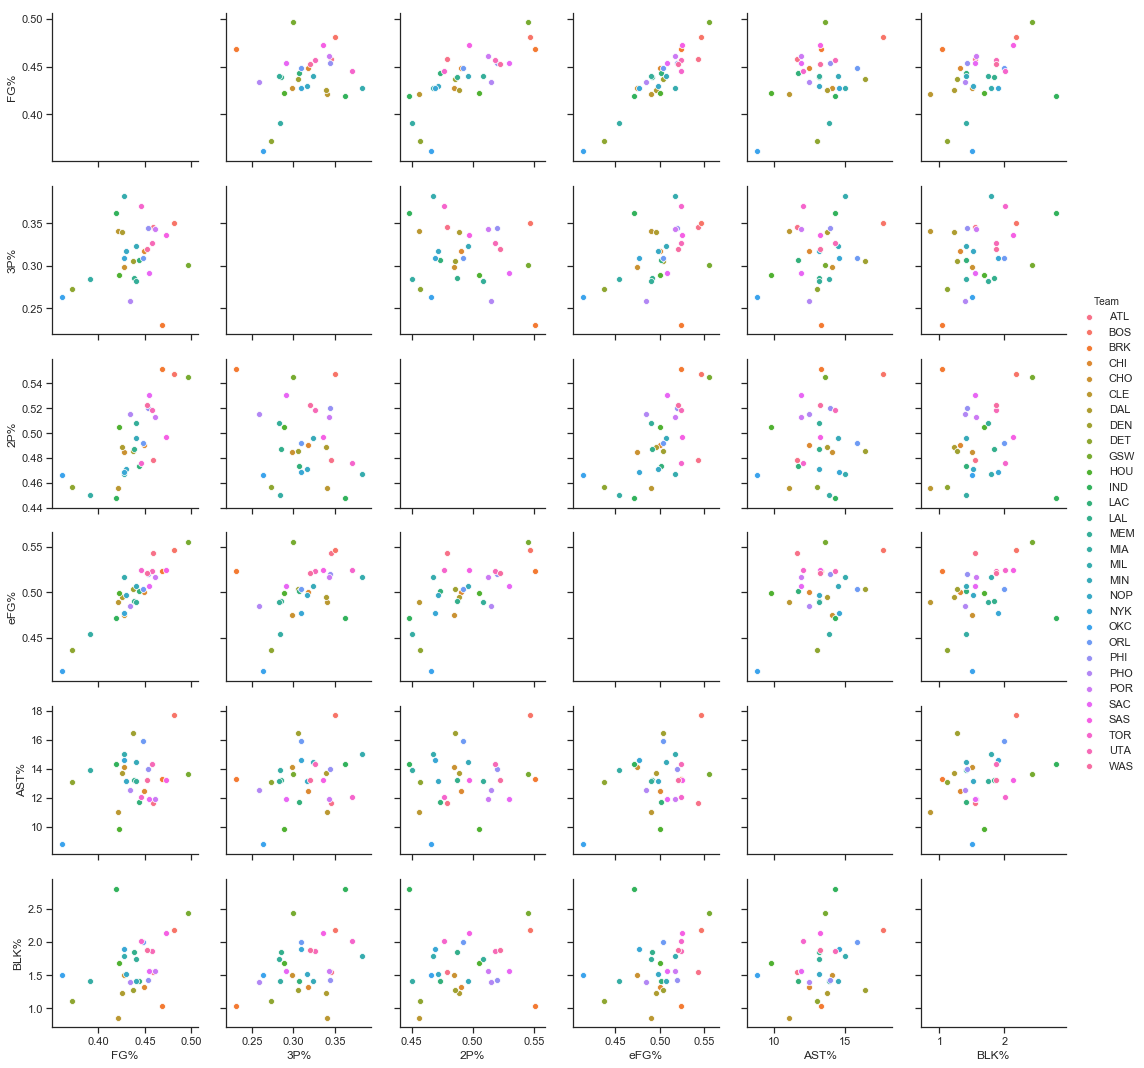

In [13]:
# mostrar diagrama de dispersión para un grupo de atributos
display(HTML("<style>.container { width:100% !important; }</style>"));
sns.pairplot(df_1, hue='Team')

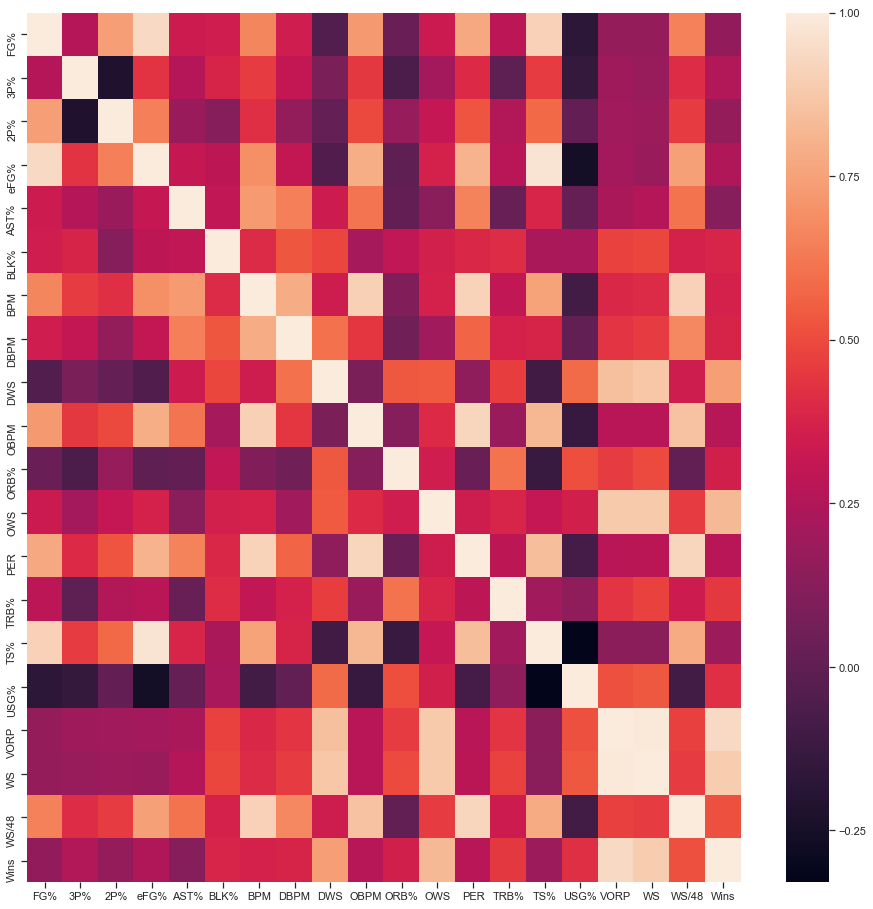

In [14]:
# mostrar diagrama de correlación entre cada par de atributos
plt.figure(figsize=(16, 16))
corr = df_team.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Puede observarse como los atributos con mayor correlación con la variable target que en este caso serían las victorias de cada equipo "Wins", serían: VORP, WS, OWS, DWS.
Estos atributos representan lo siguiente:
- VORP: Value over Replacement Player. Valor sobre el jugador de reemplazo. Una estimación de puntuación mas/menos de los puntos por 100 posesiones de EQUIPO que un jugador contribuyó por encima de un jugador de nivel de reemplazo (-2.0), traducido a un equipo promedio y prorrateado a una temporada de 82 juegos. Multiplique por 2.70 para convertir a victorias sobre reemplazo.
- WS: Win Shares. Una estimación del número de victorias aportadas por un jugador.
- OWS: Offensive Win Shares. Acciones ofensivas de victoria. Una estimación del número de victorias aportadas por un jugador debido a su ataque.
- DWS: Defensive Win Shares. Acciones de victoria defensivas. Una estimación del número de victorias aportadas por un jugador debido a su defensa.

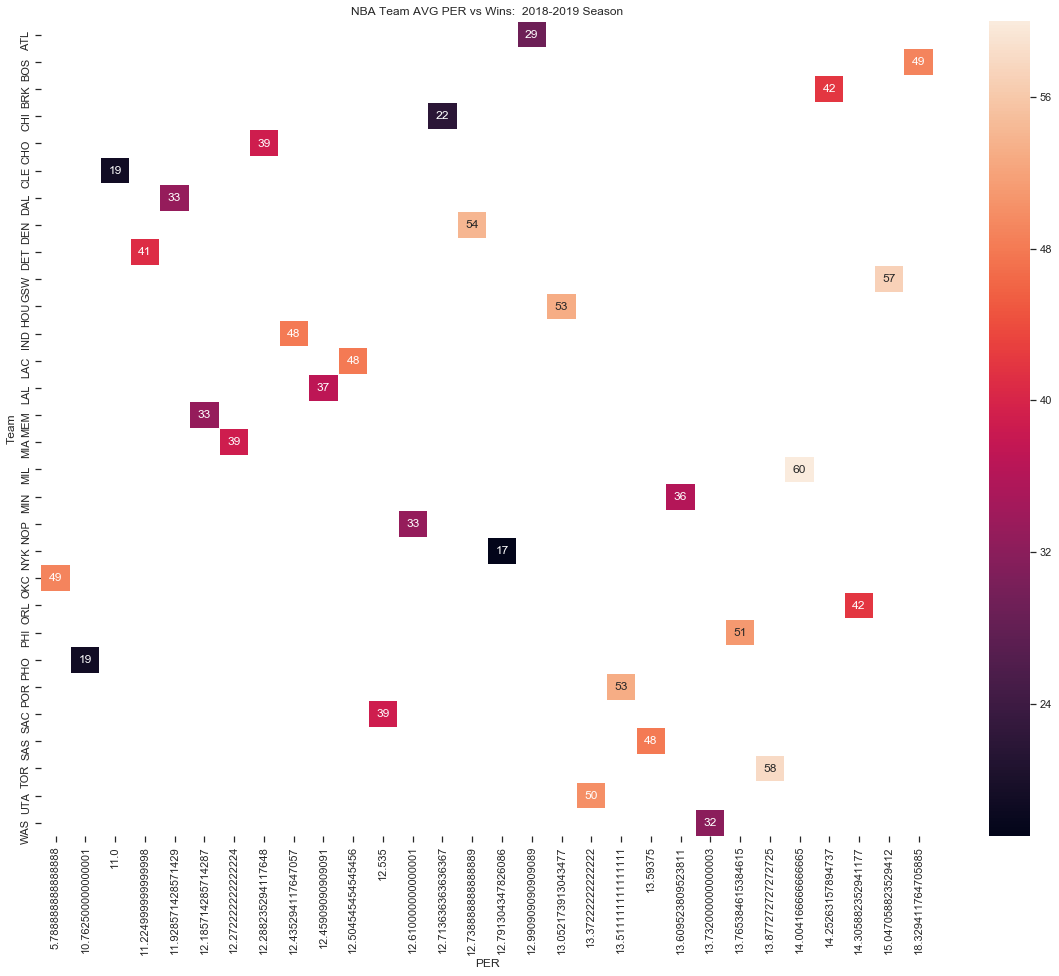

In [15]:
# pivotamos el dataframe por los atributos de equipo, PER y las victorias.
df_new = df_team.pivot("Team", "PER", "Wins")

# visualizamos la relación entre PER y victorias para cada equipo
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("NBA Team AVG PER vs Wins:  2018-2019 Season")
sns.heatmap(df_new,linewidths=.5, annot=True, fmt='g')

Algunos datos pueden ser sorprendentes como que el equipo con el menor PER medio en su plantilla, Oklahoma, sea un equipo ganador con 49 victorias en la temporada pasada, o Washington que es un equipo perdedor con 32 victorias tenga un PER medio bastante arriba.

Hacemos ahora una visualización parecida con un atributo como DWS que tiene mayor correlación como se vio antes con las victorias, y por tanto no debería tener datos muy sorprendentes como estos, aunque habrá equipos con muy buena defensa que puedan estar arriba en el DWS pero no tengan un número elevado de victorias.

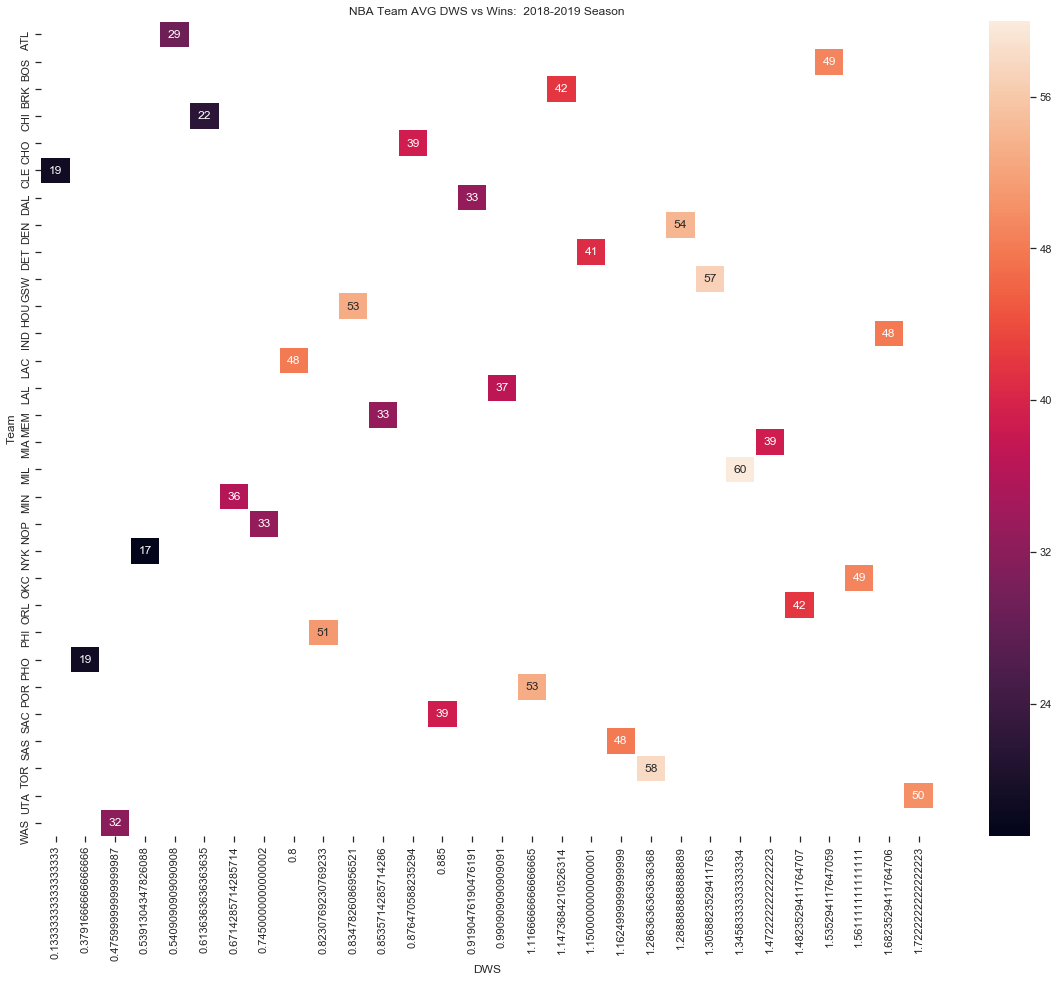

In [16]:
# pivotamos el dataframe por los atributos de equipo, DWS y las victorias.
df_new = df_team.pivot("Team", "DWS", "Wins")

# visualizamos la relación entre DWS y victorias para cada equipo
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("NBA Team AVG DWS vs Wins:  2018-2019 Season")
sns.heatmap(df_new,linewidths=.5, annot=True, fmt='g')

In [17]:
# generamos un dataframe sólo con los atributos numéricos para eliminar valores negativos
numerical_df = df_team[ list(df_team.columns[1 : ])]
# en este dataframe sustituimos los valores negativos o 0 que tenga por un valor positivo simbólico ya que para alguna operación/visualización
# no están permitidos valores =< 0
numerical_df[numerical_df < 0] = 0.001

# volvemos a añadir la columna del equipo para tenerla luego en la visualización
numerical_df['Team'] = df_team['Team']
# ver como ordenar las columnas del dataframe para poner Team en el primer lugar
numerical_df = numerical_df.reindex(columns=(['Team'] + list([a for a in numerical_df.columns if a != 'Team']) ))
numerical_df.head(5)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


,Team,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,DWS,...,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48,Wins
Tm,,,,,,,,,,,,,,,,,,,,,
ATL,ATL,0.458364,0.345401,0.478791,0.542909,11.604545,1.540909,0.001000,0.001000,0.540909,...,5.931818,0.709091,12.990909,10.854545,0.564545,17.068182,0.131818,1.263636,0.063182,29
BOS,BOS,0.481353,0.350508,0.547059,0.546353,17.682353,2.182353,3.176471,0.764706,1.535294,...,9.135294,1.541176,18.329412,11.811765,0.571353,20.023529,0.876471,3.064706,0.157471,49
BRK,BRK,0.468895,0.230737,0.551316,0.523684,13.289474,1.031579,0.001000,0.001000,1.147368,...,5.763158,1.073684,14.252632,11.752632,0.549579,19.794737,0.505263,2.210526,0.097474,42
CHI,CHI,0.448961,0.317492,0.490337,0.500388,12.459091,1.313636,0.001000,0.001000,0.613636,...,4.000000,0.372727,12.713636,9.431818,0.532706,18.927273,0.001000,0.977273,0.043955,22
CHO,CHO,0.427294,0.298390,0.485000,0.474882,14.123529,1.500000,0.001000,0.001000,0.876471,...,4.164706,1.382353,12.288235,9.158824,0.511941,19.500000,0.505882,2.264706,0.046647,39


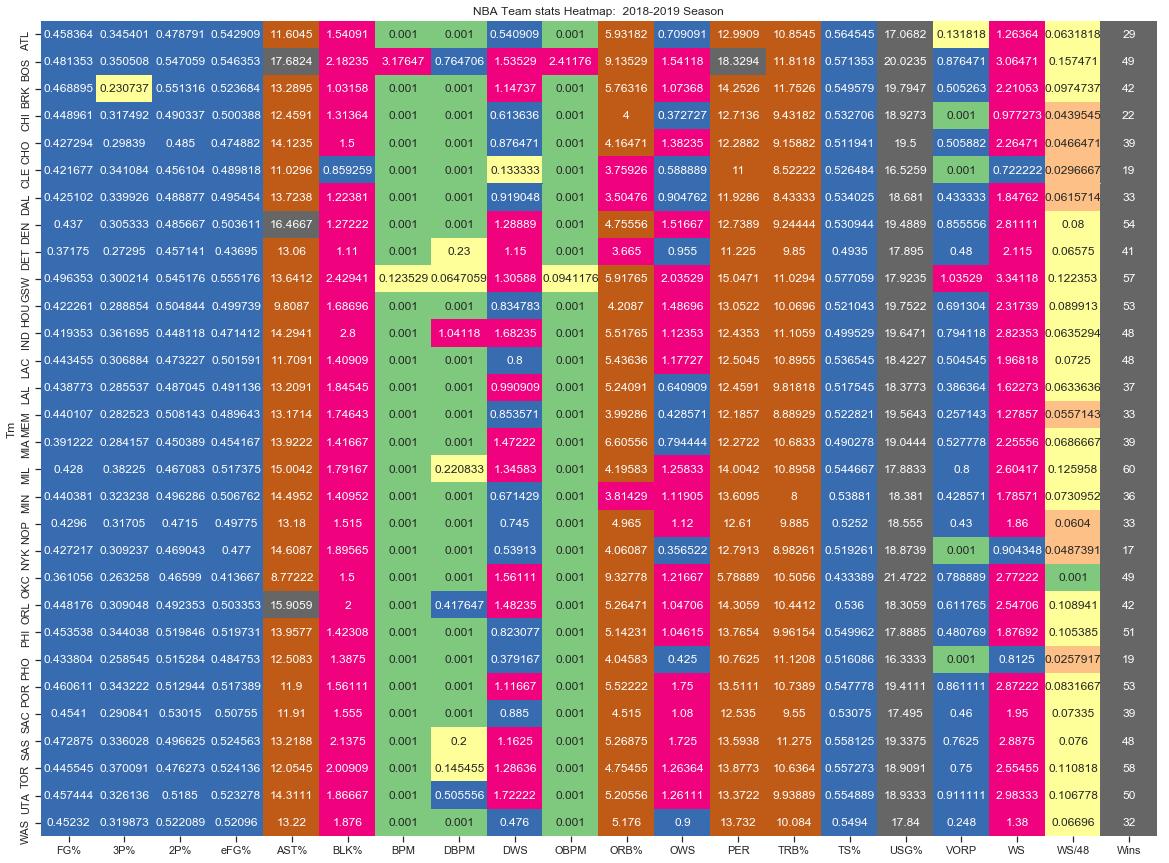

In [20]:
# división del conjunto de datos por atributos, para mejor visualización
team = numerical_df.columns[0]
vars_nba = numerical_df.columns[1:]

# visualización por equipo de los atributos 1 en forma de mapa de calor
plt.subplots(figsize=(20,15))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
norm = LogNorm()
ax = plt.axes()

grid = numerical_df.select_dtypes([np.number])
ax.set_title("NBA Team stats Heatmap:  2018-2019 Season")
sns.heatmap(grid,annot=True, yticklabels=numerical_df["Team"],fmt='g', cmap="Accent", cbar=False, norm=norm)

In [22]:
# obtenemos el dataframe solo con los atributos numéricos y normalizamos las variables antes de utilizar el algoritmo de clustering Kmeans
numerical_df = df_team[ list(df_team.columns[1 : ])]
scaler = MinMaxScaler()
scaler.fit(numerical_df)
scaler.transform(numerical_df)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.71921627, 0.7567923 , 0.29723138, 0.91331074, 0.31787673,
        0.35123178, 0.46923002, 0.28752643, 0.25651621, 0.53393823,
        0.41680399, 0.21001607, 0.57429983, 0.74887767, 0.91290197,
        0.14299754, 0.18559416, 0.20672913, 0.55749945, 0.27906977],
       [0.88913311, 0.79050031, 0.95874959, 0.93764722, 1.        ,
        0.68174674, 1.        , 0.92192691, 0.88235294, 1.        ,
        0.96694434, 0.70566728, 1.        , 1.        , 0.96028478,
        0.71809221, 0.85683425, 0.89443474, 1.        , 0.74418605],
       [0.79705296, 0.        , 1.        , 0.77745528, 0.50697926,
        0.08879068, 0.58227633, 0.60788599, 0.6382039 , 0.54920699,
        0.38783957, 0.42719459, 0.67491147, 0.98448668, 0.80872911,
        0.67357041, 0.52222268, 0.56828182, 0.71843239, 0.58139535],
       [0.64972103, 0.57258988, 0.40910795, 0.61282958, 0.41378391,
        0.23412561, 0.45136909, 0.45311084, 0.30228862, 0.43248997,
        0.08504838, 0.0096532 , 0.55218969, 0

In [49]:
# ejemplo con Kmeans para clusterizar los equipos según sus estadísticas. Probamos con 2 como número de clusters
k_means = KMeans(n_clusters=2)
kmeans = k_means.fit(scaler.transform(numerical_df))

df_aux = df_team.copy()
df_aux['cluster'] = kmeans.labels_
df_aux

,Team,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,DWS,...,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48,Wins,cluster
Tm,,,,,,,,,,,,,,,,,,,,,
ATL,ATL,0.458,0.345,0.479,0.543,11.605,1.541,-2.632,-1.482,0.541,...,0.709,12.991,10.855,0.565,17.068,0.132,1.264,0.063,29,0
BOS,BOS,0.481,0.351,0.547,0.546,17.682,2.182,3.176,0.765,1.535,...,1.541,18.329,11.812,0.571,20.024,0.876,3.065,0.157,49,1
BRK,BRK,0.469,0.231,0.551,0.524,13.289,1.032,-1.395,-0.347,1.147,...,1.074,14.253,11.753,0.550,19.795,0.505,2.211,0.097,42,1
CHI,CHI,0.449,0.317,0.490,0.500,12.459,1.314,-2.827,-0.895,0.614,...,0.373,12.714,9.432,0.533,18.927,-0.005,0.977,0.044,22,0
CHO,CHO,0.427,0.298,0.485,0.475,14.124,1.500,-3.518,-1.535,0.876,...,1.382,12.288,9.159,0.512,19.500,0.506,2.265,0.047,39,0
CLE,CLE,0.422,0.341,0.456,0.490,11.030,0.859,-3.633,-1.826,0.133,...,0.589,11.000,8.522,0.526,16.526,-0.074,0.722,0.030,19,0
DAL,DAL,0.425,0.340,0.489,0.495,13.724,1.224,-2.038,-0.305,0.919,...,0.905,11.929,8.433,0.534,18.681,0.433,1.848,0.062,33,0
DEN,DEN,0.437,0.305,0.486,0.504,16.467,1.272,-1.789,-0.650,1.289,...,1.517,12.739,9.244,0.531,19.489,0.856,2.811,0.080,54,1
DET,DET,0.372,0.273,0.457,0.437,13.060,1.110,-2.050,0.230,1.150,...,0.955,11.225,9.850,0.493,17.895,0.480,2.115,0.066,41,0


Vemos como ha clasificado en dos clusters a los 30 equipos de la liga, y el cluster 1 correspondería con los equipos que jugaron playoffs en su mayoría, y que por lógica tendrán mejores estadísticas medias de sus jugadores. Hay algunas excepciones como Oklahoma, Clippers y Houston que aunque fueron equipos ganadores el kmeans los ha clasificado con los equipos inferiores.

Obtenemos los datos de la temporada actual 2019-2020 que serán los datos con los que probaremos posteriormente el modelo entrenado para predecir las victorias de cadda equipo según la medía estadística de sus jugadores.

In [28]:
# obtención de los datos de la liga regular de la NBA en la temporada actual 2019-2020
nba_game, nba_minute, nba_advanced, nba_poss = datos_NBA_season(2020, 2020)

In [29]:
# generamos los csv de los datos conseguidos de la web de estadísticas
generar_csv(nba_game, 'NBA', 'game')
generar_csv(nba_minute, 'NBA', 'minute')
generar_csv(nba_advanced, 'NBA', 'advanced')
generar_csv(nba_poss, 'NBA', 'poss')

In [75]:
# cargar y visualizar los datos per game y advanced de 2019-2020 que serán los utilizados
df_game_2020 = pd.read_csv('./NBA_2020_game.csv', sep=',')
print("Dataset NBA 2020 per game: num_rows: %d\tColumnas: %d\n" % (df_game_2020.shape[0], df_game_2020.shape[1]))
df_adv_2020 = pd.read_csv('./NBA_2020_advanced.csv', sep=',')
print("Dataset NBA 2020 advanced: num_rows: %d\tColumnas: %d\n" % (df_adv_2020.shape[0], df_adv_2020.shape[1]))

Dataset NBA 2020 per game: num_rows: 525	Columnas: 30

Dataset NBA 2020 advanced: num_rows: 525	Columnas: 27



In [76]:
df_game_2020.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Steven Adams,C,26,OKC,44,44,26.700,4.500,7.500,0.600,...,3.400,5.900,9.300,2.600,0.700,1.100,1.500,1.900,10.800,2020
1,Bam Adebayo,PF,22,MIA,48,48,34.600,6.000,10.400,0.581,...,2.500,7.900,10.500,4.700,1.200,1.200,2.800,2.500,15.700,2020
2,LaMarcus Aldridge,C,34,SAS,44,44,33.000,7.400,14.500,0.508,...,2.000,5.500,7.500,2.300,0.600,1.700,1.400,2.400,18.900,2020
3,Nickeil Alexander-Walker,SG,21,NOP,39,0,12.700,2.000,5.800,0.342,...,0.200,1.800,2.000,1.900,0.300,0.200,1.000,1.100,5.400,2020
4,Grayson Allen,SG,24,MEM,30,0,16.600,2.600,5.900,0.449,...,0.200,2.000,2.200,1.400,0.200,0.000,0.800,1.200,7.400,2020
5,Jarrett Allen,C,21,BRK,48,44,27.300,4.400,6.800,0.651,...,3.100,6.600,9.700,1.400,0.700,1.500,1.200,2.500,11.400,2020
6,Kadeem Allen,SG,27,NYK,10,0,11.700,1.900,4.400,0.432,...,0.200,0.700,0.900,2.100,0.500,0.200,0.800,0.700,5.000,2020
7,Al-Farouq Aminu,PF,29,ORL,18,2,21.100,1.400,4.800,0.291,...,1.300,3.500,4.800,1.200,1.000,0.400,0.900,1.500,4.300,2020
8,Justin Anderson,SF,26,BRK,3,0,5.700,0.300,2.000,0.167,...,0.000,0.700,0.700,0.000,0.000,0.300,0.000,0.700,1.000,2020
9,Kyle Anderson,PF,26,MEM,43,5,17.300,2.100,4.300,0.481,...,0.900,3.000,3.900,2.100,0.700,0.500,0.900,1.400,5.100,2020


In [77]:
df_adv_2020.head(10)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Steven Adams,C,26,OKC,44,1173,21.100,0.609,0.003,0.424,...,17.100,3.000,1.800,4.800,0.197,1.600,3.300,4.900,2.000,2020
1,Bam Adebayo,PF,22,MIA,48,1659,20.400,0.619,0.022,0.503,...,19.700,3.600,2.700,6.300,0.183,1.000,3.900,4.900,2.900,2020
2,LaMarcus Aldridge,C,34,SAS,44,1453,20.600,0.587,0.188,0.245,...,22.800,3.200,1.300,4.400,0.147,1.600,0.700,2.300,1.600,2020
3,Nickeil Alexander-Walker,SG,21,NOP,39,494,8.200,0.445,0.520,0.124,...,23.000,-0.600,0.300,-0.300,-0.034,-3.800,-2.200,-6.000,-0.500,2020
4,Grayson Allen,SG,24,MEM,30,498,11.500,0.577,0.517,0.199,...,18.000,0.500,0.100,0.600,0.059,-0.700,-2.900,-3.600,-0.200,2020
5,Jarrett Allen,C,21,BRK,48,1309,20.600,0.665,0.012,0.590,...,14.900,3.600,2.100,5.700,0.209,0.200,3.200,3.400,1.800,2020
6,Kadeem Allen,SG,27,NYK,10,117,14.200,0.512,0.364,0.250,...,20.600,0.100,0.100,0.100,0.053,-1.300,-2.600,-3.900,-0.100,2020
7,Al-Farouq Aminu,PF,29,ORL,18,380,7.800,0.395,0.419,0.337,...,13.200,-0.400,0.600,0.200,0.022,-5.000,2.400,-2.600,-0.100,2020
8,Justin Anderson,SF,26,BRK,3,17,-3.800,0.218,0.500,0.333,...,16.900,-0.100,0.000,-0.100,-0.173,-12.800,-2.800,-15.600,-0.100,2020
9,Kyle Anderson,PF,26,MEM,43,742,13.000,0.524,0.203,0.267,...,13.800,0.500,0.800,1.300,0.082,-1.900,1.900,0.000,0.400,2020


In [78]:
# mergeamos ambos dataframes para juntar en uno solo tanto las estadísticas simples como avanzadas de cada jugador
df_result_2020 = mergear_dfs(df_game_2020, df_adv_2020)

print("Dataset NBA: num_rows: %d\tColumnas: %d\n" % (df_result_2020.shape[0], df_result_2020.shape[1]))
print("columns:\n", list(df_result_2020.columns))
df_result_2020.head()

Dataset NBA: num_rows: 525	Columnas: 50

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,Steven Adams,C,26,OKC,44,44,26.700,4.500,7.500,0.600,...,3.000,21.100,1.200,14.000,19.200,0.609,17.100,2.000,4.800,0.197
1,Bam Adebayo,PF,22,MIA,48,48,34.600,6.000,10.400,0.581,...,3.600,20.400,1.700,17.900,16.900,0.619,19.700,2.900,6.300,0.183
2,LaMarcus Aldridge,C,34,SAS,44,44,33.000,7.400,14.500,0.508,...,3.200,20.600,0.900,7.800,12.100,0.587,22.800,1.600,4.400,0.147
3,Nickeil Alexander-Walker,SG,21,NOP,39,0,12.700,2.000,5.800,0.342,...,-0.600,8.200,1.000,13.800,8.300,0.445,23.000,-0.500,-0.300,-0.034
4,Grayson Allen,SG,24,MEM,30,0,16.600,2.600,5.900,0.449,...,0.500,11.500,0.600,10.700,7.100,0.577,18.000,-0.200,0.600,0.059


In [79]:
# eliminar información que no vamos a necesitar y también eliminar datos vacíos o nulos del dataframe
df_result_2020 = preparar_df(df_result_2020,2020)

# tamaño final del dataset
print("Dataset NBA: num_rows: %d\tColumnas: %d\n" % (df_result_2020.shape[0], df_result_2020.shape[1]))
print("columns:\n", list(df_result_2020.columns))
df_result_2020.head()

Dataset NBA: num_rows: 511	Columnas: 21

columns:
 ['Player', 'Tm', 'FG%', '3P%', '2P%', 'eFG%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Player,Tm,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,...,OBPM,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48
0,Steven Adams,OKC,0.600,0.000,0.602,0.600,14.700,3.600,4.900,3.300,...,1.600,14.600,3.000,21.100,19.200,0.609,17.100,2.000,4.800,0.197
1,Bam Adebayo,MIA,0.581,0.091,0.592,0.582,21.600,3.300,4.900,3.900,...,1.000,8.700,3.600,20.400,16.900,0.619,19.700,2.900,6.300,0.183
2,LaMarcus Aldridge,SAS,0.508,0.425,0.527,0.548,10.900,4.500,2.300,0.700,...,1.600,6.500,3.200,20.600,12.100,0.587,22.800,1.600,4.400,0.147
3,Nickeil Alexander-Walker,NOP,0.342,0.342,0.343,0.431,20.800,1.200,-6.000,-2.200,...,-3.800,1.500,-0.600,8.200,8.300,0.445,23.000,-0.500,-0.300,-0.034
4,Grayson Allen,MEM,0.449,0.363,0.541,0.543,11.700,0.200,-3.600,-2.900,...,-0.700,1.100,0.500,11.500,7.100,0.577,18.000,-0.200,0.600,0.059


In [80]:
# comprobamos que ya no hay datos vacíos o nulos en el dataframe
df_result_2020.isnull().sum().max()

0

In [81]:
# agrupar en un dataframe por Team y sacar una media de cada estadística de los jugadores de su equipo
df_team_2020 = generar_df_medias(df_result_2020,2020)

print("Dataset NBA per team 2020: num_rows: %d\tColumnas: %d\n" % (df_team_2020.shape[0], df_team_2020.shape[1]))
print("columns:\n", list(df_team_2020.columns))
df_team_2020.head(20)

Dataset NBA per team 2020: num_rows: 30	Columnas: 20

columns:
 ['Team', 'FG%', '3P%', '2P%', 'eFG%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Team,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,DWS,OBPM,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48
Tm,,,,,,,,,,,,,,,,,,,,
ATL,ATL,0.393,0.252,0.447,0.447,13.490,1.770,-4.130,-0.985,0.355,-3.150,4.250,0.280,10.325,9.170,0.481,18.430,0.045,0.610,0.006
BOS,BOS,0.479,0.314,0.544,0.530,11.782,2.918,-0.200,0.876,1.041,-1.071,4.976,0.971,14.988,11.271,0.564,18.594,0.618,1.988,0.125
BRK,BRK,0.378,0.258,0.447,0.431,12.730,1.475,-4.875,-0.450,0.665,-4.420,4.375,0.420,8.995,10.900,0.454,18.610,0.205,1.075,0.011
CHI,CHI,0.451,0.273,0.516,0.505,11.376,1.806,-2.229,-0.447,0.888,-1.776,6.335,0.447,13.271,9.694,0.534,18.941,0.224,1.359,0.076
CHO,CHO,0.423,0.275,0.486,0.475,13.127,1.867,-4.020,-1.413,0.467,-2.613,6.027,0.480,12.207,10.287,0.508,19.840,0.020,0.960,0.032
CLE,CLE,0.479,0.312,0.569,0.533,12.711,2.339,-1.650,-0.239,0.228,-1.400,4.744,0.444,14.783,12.411,0.559,17.094,-0.022,0.667,0.083
DAL,DAL,0.449,0.347,0.497,0.524,12.600,1.629,-3.329,-1.447,0.618,-1.876,4.641,1.371,12.341,10.082,0.547,20.271,0.624,1.988,0.055
DEN,DEN,0.455,0.321,0.513,0.515,14.920,1.600,-0.607,0.160,0.967,-0.767,5.047,1.007,14.007,10.093,0.545,18.860,0.573,1.967,0.099
DET,DET,0.435,0.315,0.491,0.505,15.541,1.300,-3.465,-1.765,0.529,-1.700,3.465,0.735,11.947,8.024,0.537,19.424,0.212,1.259,0.047


In [82]:
# guardamos en un fichero .csv el dataset con las estadísticas medias por jugador/equipo en 2020
df_team_2020.to_csv('./df_team_2020.csv', index=False)

Obtenemos los datos de las últimas 20 temporadas para entrenar el modelo con estos datos.

In [38]:
# obtención de los datos de la liga regular de la NBA en las últimas 20 temporadas para entrenar el modelo
nba_game_2, nba_minute_2, nba_advanced_2, nba_poss_2 = datos_NBA_season(2000, 2019)

In [39]:
# generamos los csv de los datos conseguidos de la web de estadísticas
generar_csv(nba_game_2, 'NBA', 'game')
generar_csv(nba_minute_2, 'NBA', 'minute')
generar_csv(nba_advanced_2, 'NBA', 'advanced')
generar_csv(nba_poss_2, 'NBA', 'poss')

In [40]:
# concatenar todos los datos de la NBA, por temporada regular o playoffs, y por tipo de datos, para luego generar
# unos ficheros totales, y no tener separados los datos por año.
df_NBA_season_game = concatenar_dataframes(nba_game_2, 'NBA', 'game')
df_NBA_season_minute = concatenar_dataframes(nba_minute_2, 'NBA', 'minute')
df_NBA_season_advanced = concatenar_dataframes(nba_advanced_2, 'NBA', 'advanced')
df_NBA_season_poss = concatenar_dataframes(nba_poss_2, 'NBA', 'poss')

df_NBA_season_game.to_csv('./df_NBA_season_game_2000s.csv', index=False)
df_NBA_season_minute.to_csv('./df_NBA_season_minute_2000s.csv', index=False)
df_NBA_season_advanced.to_csv('./df_NBA_season_advanced_2000s.csv', index=False)
df_NBA_season_poss.to_csv('./df_NBA_season_poss_2000s.csv', index=False)

In [41]:
# cargar y visualizar los datos per game y advanced de 2019-2020 que serán los utilizados
df_game_2000s = pd.read_csv('./df_NBA_season_game_2000s.csv', sep=',')
print("Dataset NBA 2000s per game: num_rows: %d\tColumnas: %d\n" % (df_game_2000s.shape[0], df_game_2000s.shape[1]))
df_adv_2000s = pd.read_csv('./df_NBA_season_advanced_2000s.csv', sep=',')
print("Dataset NBA 2000s advanced: num_rows: %d\tColumnas: %d\n" % (df_adv_2000s.shape[0], df_adv_2000s.shape[1]))

Dataset NBA 2000s per game: num_rows: 11576	Columnas: 30

Dataset NBA 2000s advanced: num_rows: 11576	Columnas: 27



In [42]:
df_game_2000s.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Tariq Abdul-Wahad,SG,25,TOT,61,56,25.900,4.500,10.600,0.424,...,1.700,3.100,4.800,1.600,1.000,0.500,1.700,2.400,11.400,2000
1,Tariq Abdul-Wahad,SG,25,ORL,46,46,26.200,4.800,11.200,0.433,...,1.700,3.500,5.200,1.600,1.200,0.300,1.900,2.500,12.200,2000
2,Tariq Abdul-Wahad,SG,25,DEN,15,10,24.900,3.400,8.700,0.389,...,1.600,1.900,3.500,1.700,0.400,0.800,1.300,2.100,8.900,2000
3,Shareef Abdur-Rahim,SF,23,VAN,82,82,39.300,7.200,15.600,0.465,...,2.700,7.400,10.100,3.300,1.100,1.100,3.000,3.000,20.300,2000
4,Cory Alexander,PG,26,DEN,29,2,11.300,1.000,3.400,0.286,...,0.300,1.200,1.400,2.000,0.800,0.100,1.000,1.300,2.800,2000
5,Ray Allen*,SG,24,MIL,82,82,37.400,7.800,17.200,0.455,...,1.000,3.400,4.400,3.800,1.300,0.200,2.200,2.300,22.100,2000
6,Rafer Alston,PG,23,MIL,27,0,13.400,1.000,3.500,0.284,...,0.200,0.700,0.900,2.600,0.400,0.000,1.100,1.100,2.200,2000
7,John Amaechi,C,29,ORL,80,53,21.100,3.800,8.800,0.437,...,0.800,2.600,3.300,1.200,0.400,0.500,1.700,2.000,10.500,2000
8,Derek Anderson,SG,25,LAC,64,58,34.400,5.900,13.400,0.438,...,1.300,2.800,4.000,3.400,1.400,0.200,2.600,2.300,16.900,2000
9,Kenny Anderson,PG,29,BOS,82,82,31.600,5.300,12.000,0.440,...,0.700,2.100,2.700,5.100,1.700,0.100,1.600,2.800,14.000,2000


In [43]:
df_adv_2000s.head(10)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Tariq Abdul-Wahad,SG,25,TOT,61,1578,13.600,0.477,0.036,0.299,...,22.500,0.400,1.800,2.200,0.068,-1.600,0.100,-1.500,0.200,2000
1,Tariq Abdul-Wahad,SG,25,ORL,46,1205,14.400,0.484,0.041,0.293,...,23.300,0.400,1.600,2.000,0.082,-1.300,0.400,-0.800,0.400,2000
2,Tariq Abdul-Wahad,SG,25,DEN,15,373,10.800,0.448,0.015,0.321,...,19.700,0.000,0.200,0.200,0.023,-2.800,-1.000,-3.800,-0.200,2000
3,Shareef Abdur-Rahim,SF,23,VAN,82,3223,20.200,0.547,0.075,0.431,...,25.000,6.200,2.600,8.800,0.132,1.800,0.500,2.300,3.500,2000
4,Cory Alexander,PG,26,DEN,29,329,8.800,0.381,0.357,0.224,...,18.000,-0.500,0.400,-0.100,-0.012,-3.600,0.100,-3.500,-0.100,2000
5,Ray Allen*,SG,24,MIL,82,3070,20.600,0.570,0.288,0.282,...,25.600,9.000,1.000,10.100,0.157,5.000,-2.000,3.000,3.900,2000
6,Rafer Alston,PG,23,MIL,27,361,4.300,0.310,0.147,0.042,...,15.500,-0.700,0.000,-0.700,-0.095,-6.000,-3.400,-9.500,-0.700,2000
7,John Amaechi,C,29,ORL,80,1684,13.200,0.505,0.009,0.416,...,24.100,0.600,1.800,2.400,0.067,-2.700,-0.900,-3.600,-0.700,2000
8,Derek Anderson,SG,25,LAC,64,2201,16.900,0.542,0.207,0.359,...,23.400,3.100,0.300,3.300,0.073,1.700,-1.900,-0.200,1.000,2000
9,Kenny Anderson,PG,29,BOS,82,2593,17.400,0.524,0.223,0.257,...,20.500,5.400,1.900,7.300,0.136,2.600,-1.400,1.200,2.100,2000


In [44]:
# mergeamos ambos dataframes para juntar en uno solo tanto las estadísticas simples como avanzadas de cada jugador
df_result_2000s = mergear_dfs(df_game_2000s, df_adv_2000s)

print("Dataset NBA: num_rows: %d\tColumnas: %d\n" % (df_result_2000s.shape[0], df_result_2000s.shape[1]))
print("columns:\n", list(df_result_2000s.columns))
df_result_2000s.head()

Dataset NBA: num_rows: 11576	Columnas: 50

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,Tariq Abdul-Wahad,SG,25,TOT,61,56,25.900,4.500,10.600,0.424,...,0.400,13.600,1.800,12.700,10.000,0.477,22.500,0.200,2.200,0.068
1,Tariq Abdul-Wahad,SG,25,ORL,46,46,26.200,4.800,11.200,0.433,...,0.400,14.400,2.200,13.000,10.800,0.484,23.300,0.400,2.000,0.082
2,Tariq Abdul-Wahad,SG,25,DEN,15,10,24.900,3.400,8.700,0.389,...,0.000,10.800,0.800,11.300,7.600,0.448,19.700,-0.200,0.200,0.023
3,Shareef Abdur-Rahim,SF,23,VAN,82,82,39.300,7.200,15.600,0.465,...,6.200,20.200,1.500,14.100,15.300,0.547,25.000,3.500,8.800,0.132
4,Cory Alexander,PG,26,DEN,29,2,11.300,1.000,3.400,0.286,...,-0.500,8.800,3.700,20.600,6.900,0.381,18.000,-0.100,-0.100,-0.012


In [45]:
# eliminar información que no vamos a necesitar y también eliminar datos vacíos o nulos del dataframe
df_result_2000s = preparar_df(df_result_2000s,2000)

# tamaño final del dataset
print("Dataset NBA: num_rows: %d\tColumnas: %d\n" % (df_result_2000s.shape[0], df_result_2000s.shape[1]))
print("columns:\n", list(df_result_2000s.columns))
df_result_2000s.head()

Dataset NBA: num_rows: 10480	Columnas: 22

columns:
 ['Player', 'Tm', 'FG%', '3P%', '2P%', 'eFG%', 'Year', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']


,Player,Tm,FG%,3P%,2P%,eFG%,Year,AST%,BLK%,BPM,...,OBPM,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48
1,Tariq Abdul-Wahad,ORL,0.433,0.095,0.447,0.435,2000,9.700,0.900,-0.800,...,-1.300,7.000,0.400,14.400,10.800,0.484,23.300,0.400,2.000,0.082
2,Tariq Abdul-Wahad,DEN,0.389,0.500,0.388,0.393,2000,11.000,2.200,-3.800,...,-2.800,6.900,0.000,10.800,7.600,0.448,19.700,-0.200,0.200,0.023
3,Shareef Abdur-Rahim,VAN,0.465,0.302,0.478,0.477,2000,15.500,1.900,2.300,...,1.800,8.000,6.200,20.200,15.300,0.547,25.000,3.500,8.800,0.132
4,Cory Alexander,DEN,0.286,0.257,0.302,0.332,2000,25.700,0.400,-3.500,...,-3.600,2.600,-0.500,8.800,6.900,0.381,18.000,-0.100,-0.100,-0.012
5,Ray Allen*,MIL,0.455,0.423,0.468,0.516,2000,17.000,0.500,3.000,...,5.000,3.200,9.000,20.600,6.800,0.570,25.600,3.900,10.100,0.157


In [46]:
# lista con las victorias de cada equipo desde la temporada 1999-2000 hasta la 2018-2019, ordenada alfabeticamente por equipo para poder
# asignarla directamente al dataframe
lista_victorias = [28,25,33,35,28,13,26,30,37,47,53,44,40,44,38,60,48,43,24,29,35,36,49,\
        44,36,45,33,24,66,62,50,56,39,41,25,40,48,53,55,49,49,44,38,21,20,28,42,18,26,33,32,35,44,34,7,21,43,49,46,44,17,\
        15,21,30,23,47,41,49,33,41,41,62,50,45,48,50,42,41,27,22,33,48,36,36,39,32,30,29,17,35,42,50,50,45,66,61,19,21,24,33,53,\
        57,51,50,19,40,53,57,60,52,58,60,67,51,50,55,57,36,41,49,50,42,33,24,33,35,40,27,17,43,49,44,45,50,54,53,50,38,57,36,30,\
        33,40,46,54,42,32,50,50,54,54,64,53,59,39,27,30,25,29,29,32,44,37,39,41,19,17,21,38,37,34,34,42,48,29,26,36,23,\
        47,51,67,73,67,58,57,34,45,28,43,45,51,34,52,55,53,42,43,34,45,54,56,41,55,65,53,56,41,42,48,61,44,41,35,36,36,32,37,42,\
        49,56,38,45,42,48,48,15,31,39,27,28,37,47,40,23,19,29,32,40,56,57,56,53,51,42,48,67,56,58,50,56,34,45,42,57,65,57,\
        57,41,45,27,21,17,26,35,37,23,28,50,45,49,22,22,24,40,46,41,56,50,55,42,43,22,33,52,50,36,25,42,59,52,44,15,43,47,58,46,66,\
        54,37,48,41,44,39,42,52,41,42,41,30,40,28,26,34,46,35,31,38,15,41,33,42,44,60,50,47,50,51,58,44,33,32,22,24,15,17,26,\
        31,40,16,29,31,47,36,31,26,52,49,47,42,49,41,32,34,12,24,22,47,41,18,56,49,37,46,21,27,38,39,34,45,30,34,48,33,50,48,\
        30,37,39,33,23,33,23,32,29,42,36,54,37,17,32,31,29,17,23,50,55,47,60,59,45,55,47,48,49,41,43,44,42,21,36,36,40,\
        52,59,59,52,37,20,23,25,35,29,25,42,49,56,43,48,33,43,38,35,40,41,27,41,35,34,19,18,10,28,52,51,53,51,36,44,29,\
        62,54,61,55,46,54,40,33,25,48,39,23,24,21,19,59,50,49,50,41,27,21,32,41,54,50,48,28,33,54,51,44,41,49,53,44,55,\
        61,59,55,50,44,33,38,17,25,24,22,28,28,29,33,32,27,39,53,58,58,60,57,59,63,58,56,54,50,61,50,58,62,55,67,61,47,\
        48,45,44,45,40,37,52,35,31,20,45,47,42,24,33,33,27,47,41,33,40,22,23,34,48,49,56,51,59,58,55,53,44,47,42,26,41,\
        51,54,48,53,39,36,43,25,38,40,51,48,50,22,23,29,19,37,37,25,45,42,41,43,19,26,23,20,29,44,46,41,49,43,32]

In [47]:
# agrupar en un dataframe por Team y sacar una media de cada estadística de los jugadores de su equipo
df_team_2000s = generar_df_medias_2000s(df_result_2000s,lista_victorias)

print("Dataset NBA per team 2000s: num_rows: %d\tColumnas: %d\n" % (df_team_2000s.shape[0], df_team_2000s.shape[1]))
print("columns:\n", list(df_team_2000s.columns))
df_team_2000s.head(20)

Dataset NBA per team 2000s: num_rows: 595	Columnas: 20

columns:
 ['FG%', '3P%', '2P%', 'eFG%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'Wins']


FG%   3P%   2P%  eFG%   AST%  BLK%    BPM   DBPM   DWS   OBPM  \
Tm  Year                                                                   
ATL 2000 0.430 0.239 0.440 0.453 13.871 1.150 -2.900 -1.579 0.779 -1.321   
    2001 0.371 0.201 0.381 0.392 14.757 1.052 -4.783 -0.991 0.730 -3.804   
    2002 0.435 0.293 0.447 0.457 12.233 1.689 -3.678 -1.356 0.878 -2.306   
    2003 0.385 0.251 0.403 0.408 12.267 1.871 -5.481 -1.648 0.652 -3.829   
    2004 0.425 0.273 0.446 0.444 10.152 1.943 -4.283 -1.674 0.526 -2.591   
    2005 0.457 0.273 0.472 0.474 12.080 1.405 -3.540 -1.690 0.415 -1.865   
    2006 0.432 0.311 0.449 0.459 10.513 1.147 -3.253 -2.053 0.493 -1.207   
    2007 0.429 0.278 0.444 0.457 11.589 1.258 -3.553 -1.542 0.837 -2.016   
    2008 0.426 0.224 0.441 0.456 12.338 1.281 -3.456 -1.506 1.050 -1.950   
    2009 0.441 0.333 0.463 0.471 12.193 1.520 -2.853 -0.713 1.433 -2.127   
    2010 0.455 0.265 0.478 0.480 10.829 1.507 -2.136 -0.686 1.564 -1.436   
    2011 0.448 0.380 0.464 0.483 12.865 1.400 -2.294 -0.265 1.194 -2.029   
    2012 0.423 0.306 0.443 0.465 14.850 1.375 -0.562  0.569 1.450 -1.181   
    2013 0.442 0.301 0.472 0.500 13.317 0.917 -2.689 -0.750 1.317 -1.928   
    2014 0.423 0.273 0.490 0.471 13.617 1.272 -3.728 -1.444 1.128 -2.278   
    2015 0.443 0.316 0.486 0.505 14.406 1.537 -0.569 -0.037 1.606 -0.544   
    2016 0.439 0.285 0.507 0.492 15.576 1.841 -1.012  0.729 1.876 -1.747   
    2017 0.423 0.277 0.465 0.474 13.305 1.430 -3.380 -0.205 1.365 -3.175   
    2018 0.448 0.353 0.490 0.518 12.700 1.191 -3.582 -1.241 0.700 -2.327   
    2019 0.458 0.344 0.477 0.543 11.605 1.541 -2.632 -1.482 0.541 -1.159   

          ORB%   OWS    PER   TRB%   TS%   USG%   VORP    WS  WS/48  Wins  
Tm  Year                                                                   
ATL 2000 5.557 1.186 12.864  8.814 0.497 19.179  0.221 1.979  0.049    28  
    2001 4.700 0.465  9.874  8.939 0.426 17.909  0.122 1.200  0.004    25  
    2002 6.367 0.889 12.872  9.889 0.500 17.556  0.233 1.767  0.068    33  
    2003 6.614 0.924  9.724  9.952 0.453 19.105  0.224 1.576  0.001    35  
    2004 7.339 0.774 12.165 11.322 0.487 18.796  0.152 1.300  0.042    28  
    2005 8.070 0.445 12.550 10.525 0.506 17.875 -0.140 0.860  0.045    13  
    2006 6.480 1.567 12.720 10.133 0.536 17.220  0.247 2.080  0.070    26  
    2007 5.716 0.737 11.853  9.747 0.503 18.042  0.184 1.579  0.058    30  
    2008 5.994 1.325 11.712  9.756 0.502 17.706  0.456 2.400  0.063    37  
    2009 5.513 1.640 11.887  9.667 0.509 17.853  0.833 3.073  0.072    47  
    2010 7.314 2.293 13.186 11.286 0.516 18.679  1.121 3.871  0.095    53  
    2011 5.459 1.118 12.165 10.006 0.526 18.524  0.500 2.324  0.066    44  
    2012 5.350 1.169 13.294 10.375 0.495 18.106  0.675 2.619  0.102    40  
    2013 4.367 1.078 12.917 10.539 0.533 17.850  0.550 2.394  0.090    44  
    2014 9.628 1.078 12.072 12.333 0.492 19.244  0.489 2.217  0.044    38  
    2015 4.775 1.825 14.250  9.919 0.536 18.906  1.013 3.431  0.110    60  
    2016 4.094 1.059 13.135  9.424 0.521 18.418  0.853 2.947  0.099    48  
    2017 3.905 0.615 10.645  9.620 0.494 18.260  0.415 1.970  0.048    43  
    2018 4.509 0.582 11.023  9.686 0.545 17.605  0.164 1.282  0.038    24  
    2019 5.932 0.709 12.991 10.855 0.565 17.068  0.132 1.264  0.063    29

In [48]:
# guardamos en un fichero .csv el dataset con las estadísticas medias por jugador/equipo desde el 2000
df_team_2000s.to_csv('./df_team_2000s.csv', index=False)

#### Modelo de predicción para predecir las victorias de cada equipo según las estadísticas de lo que va de temporada.
Entrenaremos los modelos con los datos de los últimos 20 años, y luego usaremos el modelo para predecir las victorias de esta temporada.

In [68]:
# obtenemos lista de atributos predictivos y del target a predecir
vars_nba = list(df_team_2000s.columns[0:-1])
target_nba = df_team_2000s.columns[-1]
print(vars_nba)
print(target_nba)

['FG%', '3P%', '2P%', 'eFG%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DWS', 'OBPM', 'ORB%', 'OWS', 'PER', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']
Wins


In [69]:
# Función que genera los conjuntos de train y test a partir de un dataframe. Reparto 80% train - 20% test
def split_df(df, vars_nba):
    X = df[list(vars_nba)]
    y = df['Wins']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [70]:
# repartimos en train y test los datos desde la temporada 1999-2000 hasta la anterior, para entrenar y evaluar los modelos
X_train, X_test, y_train, y_test = split_df(df_team_2000s, vars_nba)

In [72]:
# Defino el algoritmo a utilizar de regresión lineal
lr = LinearRegression()

# Entreno el modelo
lr.fit(X_train, y_train)
# Realizo una predicción
y_pred = lr.predict(X_test)

print(lr.coef_)
print("\n")
print(lr.score(X_train, y_train))

[-5.55166448e+01  1.01706456e+01  3.75058573e+01  9.14626913e+01
  2.00853407e-01  5.04436185e-01 -2.23127069e+01  2.20724077e+01
 -8.19462194e+00  1.86054589e+01  5.58312997e-01 -1.69973779e-01
 -2.04685286e+00 -4.23541319e-01 -5.79452838e+01  7.89289747e-01
  3.33583442e+01  6.14995664e-01  2.09610702e+02]


0.9064511141043378


In [92]:
# copiamos el dataframe de datos de la temporada actual y eliminamos la columna del equipo para no dar error luego por ser tipo string
df_team_2020_aux = df_team_2020.copy()
df_team_2020_aux = df_team_2020_aux.drop(columns=['Team'], axis=1)
df_team_2020_aux.head(10)

,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,DWS,OBPM,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48
Tm,,,,,,,,,,,,,,,,,,,
ATL,0.393,0.252,0.447,0.447,13.490,1.770,-4.130,-0.985,0.355,-3.150,4.250,0.280,10.325,9.170,0.481,18.430,0.045,0.610,0.006
BOS,0.479,0.314,0.544,0.530,11.782,2.918,-0.200,0.876,1.041,-1.071,4.976,0.971,14.988,11.271,0.564,18.594,0.618,1.988,0.125
BRK,0.378,0.258,0.447,0.431,12.730,1.475,-4.875,-0.450,0.665,-4.420,4.375,0.420,8.995,10.900,0.454,18.610,0.205,1.075,0.011
CHI,0.451,0.273,0.516,0.505,11.376,1.806,-2.229,-0.447,0.888,-1.776,6.335,0.447,13.271,9.694,0.534,18.941,0.224,1.359,0.076
CHO,0.423,0.275,0.486,0.475,13.127,1.867,-4.020,-1.413,0.467,-2.613,6.027,0.480,12.207,10.287,0.508,19.840,0.020,0.960,0.032
CLE,0.479,0.312,0.569,0.533,12.711,2.339,-1.650,-0.239,0.228,-1.400,4.744,0.444,14.783,12.411,0.559,17.094,-0.022,0.667,0.083
DAL,0.449,0.347,0.497,0.524,12.600,1.629,-3.329,-1.447,0.618,-1.876,4.641,1.371,12.341,10.082,0.547,20.271,0.624,1.988,0.055
DEN,0.455,0.321,0.513,0.515,14.920,1.600,-0.607,0.160,0.967,-0.767,5.047,1.007,14.007,10.093,0.545,18.860,0.573,1.967,0.099
DET,0.435,0.315,0.491,0.505,15.541,1.300,-3.465,-1.765,0.529,-1.700,3.465,0.735,11.947,8.024,0.537,19.424,0.212,1.259,0.047


In [93]:
# usamos el modelo de regresión lineal para predecir las victorias de cada equipo, y se añaden las victorias al dataframe
predictions = lr.predict(df_team_2020_aux)
df_team_2020_aux['Wins'] = predictions

In [103]:
# ordenamos el dataframe por las victorias predecidas
df_team_2020_aux.sort_values(by=['Wins'], ascending=False)

,FG%,3P%,2P%,eFG%,AST%,BLK%,BPM,DBPM,DWS,OBPM,ORB%,OWS,PER,TRB%,TS%,USG%,VORP,WS,WS/48,Wins
Tm,,,,,,,,,,,,,,,,,,,,
MIL,0.450,0.328,0.521,0.530,15.106,2.100,0.475,1.006,1.388,-0.544,4.394,1.150,14.188,9.925,0.555,18.775,0.825,2.525,0.135,56.705
LAL,0.419,0.368,0.482,0.483,15.256,1.881,-1.506,0.144,1.062,-1.650,3.737,1.088,13.025,9.213,0.500,15.825,0.688,2.138,0.107,52.732
TOR,0.430,0.323,0.492,0.505,12.533,2.067,-1.083,0.467,1.072,-1.544,5.072,0.822,13.022,10.317,0.542,17.900,0.556,1.894,0.119,50.705
HOU,0.462,0.302,0.583,0.549,11.547,1.787,-0.727,-0.253,0.767,-0.480,4.720,1.240,13.540,10.893,0.567,17.553,0.607,2.020,0.106,49.838
BOS,0.479,0.314,0.544,0.530,11.782,2.918,-0.200,0.876,1.041,-1.071,4.976,0.971,14.988,11.271,0.564,18.594,0.618,1.988,0.125,48.978
DAL,0.449,0.347,0.497,0.524,12.600,1.629,-3.329,-1.447,0.618,-1.876,4.641,1.371,12.341,10.082,0.547,20.271,0.624,1.988,0.055,48.537
PHI,0.456,0.311,0.534,0.515,13.744,2.288,-1.219,0.844,1.113,-2.056,4.488,0.800,12.313,9.956,0.533,18.531,0.531,1.925,0.086,48.012
LAC,0.472,0.360,0.536,0.558,16.459,1.512,0.882,-0.082,0.947,0.965,4.124,0.947,15.818,9.012,0.589,18.812,0.594,1.882,0.147,46.947
UTA,0.429,0.292,0.500,0.487,10.900,2.084,-2.200,0.942,0.758,-3.142,4.342,0.842,9.795,10.921,0.515,16.337,0.468,1.605,0.052,46.165


Los resultados que se obtienen parecen bastante coherentes con la clasificación actual de mitad de temporada, los equipos que más victorias ganarán serían Milwaukee, Toronto o Boston en el Este; y Lakers, Houston, Dallas o Clippers en el Oeste.